# ARCHモデルによる株価データの分析

このノートブックでは、ARCHモデル（Autoregressive Conditional Heteroskedasticity）を使用して株価データのボラティリティをモデル化します。以下の手順で分析を進めます：

1. 必要なライブラリのインポート
2. 擬似株価データの生成
3. データの可視化と統計分析
4. ARCHモデルのフィッティング
5. モデル診断と評価
6. 予測と信頼区間の計算

## 1. 必要なライブラリのインポート

以下のライブラリを使用します：
- numpy: 数値計算用
- pandas: データフレーム操作用
- matplotlib: 基本的な可視化用
- scipy: 統計計算用
- arch: ARCHモデル分析用

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import arch
from arch import arch_model
import seaborn as sns



# プロットのスタイル設定
sns.set_style("darkgrid")  # seabornのスタイルを直接設定
plt.style.use('default')   # matplotlibのデフォルトスタイル
%matplotlib inline

## 2. 擬似株価データの生成

ARCHプロセスを持つ擬似的な株価データを生成します。以下の手順で生成します：

1. ボラティリティに条件付き不均一分散性を持つ収益率データを生成
2. 収益率から株価データを生成
3. 日付インデックスを設定

In [11]:
# パラメータの設定
np.random.seed(42)  # 再現性のため
n = 1000  # データ点数
omega = 0.1  # 定数項
alpha = 0.3  # ARCHパラメータ
initial_price = 100  # 初期株価

# ARCH(1)プロセスによる収益率の生成
epsilon = np.random.normal(0, 1, n)
sigma2 = np.zeros(n)
returns = np.zeros(n)

for t in range(1, n):
    sigma2[t] = omega + alpha * returns[t-1]**2
    returns[t] = np.sqrt(sigma2[t]) * epsilon[t]

# 収益率から株価を生成
prices = initial_price * np.exp(np.cumsum(returns))

# 日付インデックスの作成
dates = pd.date_range(start='2024-01-01', periods=n, freq='D')
df = pd.DataFrame({
    'Price': prices,
    'Returns': returns,
    'Volatility': np.sqrt(sigma2)
}, index=dates)

## 3. データの可視化と統計分析

生成したデータの特性を確認するため、以下の分析を行います：
1. 株価の時系列プロット
2. 収益率の時系列プロット
3. 収益率の分布
4. 収益率の自己相関分析

/tmp/ipykernel_216/4165156954.py:35: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_216/4165156954.py:35: UserWarning: Glyph 20184 (\N{CJK UNIFIED IDEOGRAPH-4ED8}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_216/4165156954.py:35: UserWarning: Glyph 26666 (\N{CJK UNIFIED IDEOGRAPH-682A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_216/4165156954.py:35: UserWarning: Glyph 20385 (\N{CJK UNIFIED IDEOGRAPH-4FA1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_216/4165156954.py:35: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_216/4165156954.py:35: UserWarning: Glyph 25512 (\N{CJK UNIFIED IDEOGRAPH-63A8}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_216/4165156954.py:35: UserWarning: Glyph 31227 (\N{CJK UNIFIED IDEOGRAPH-79FB}) missing from 

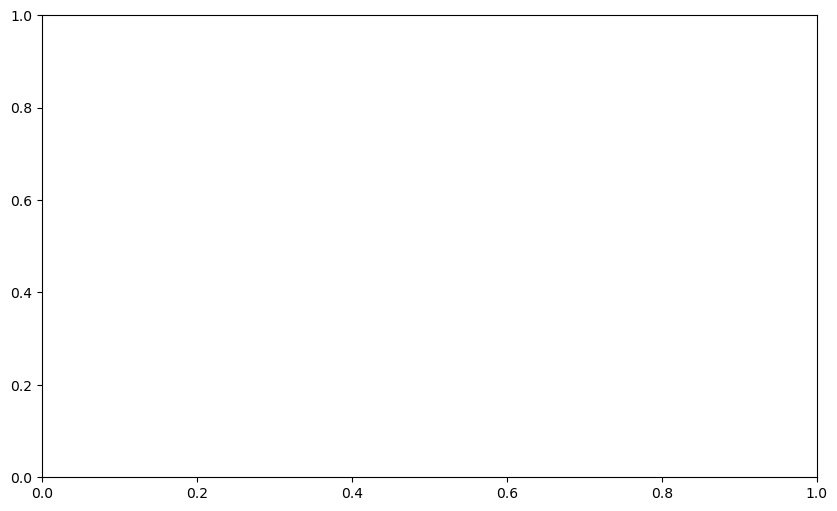

/home/kazumasa/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26666 (\N{CJK UNIFIED IDEOGRAPH-682A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/kazumasa/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20385 (\N{CJK UNIFIED IDEOGRAPH-4FA1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/kazumasa/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/kazumasa/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25512 (\N{CJK UNIFIED IDEOGRAPH-63A8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/kazumasa/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31227 (\N{CJK UNIFIED I

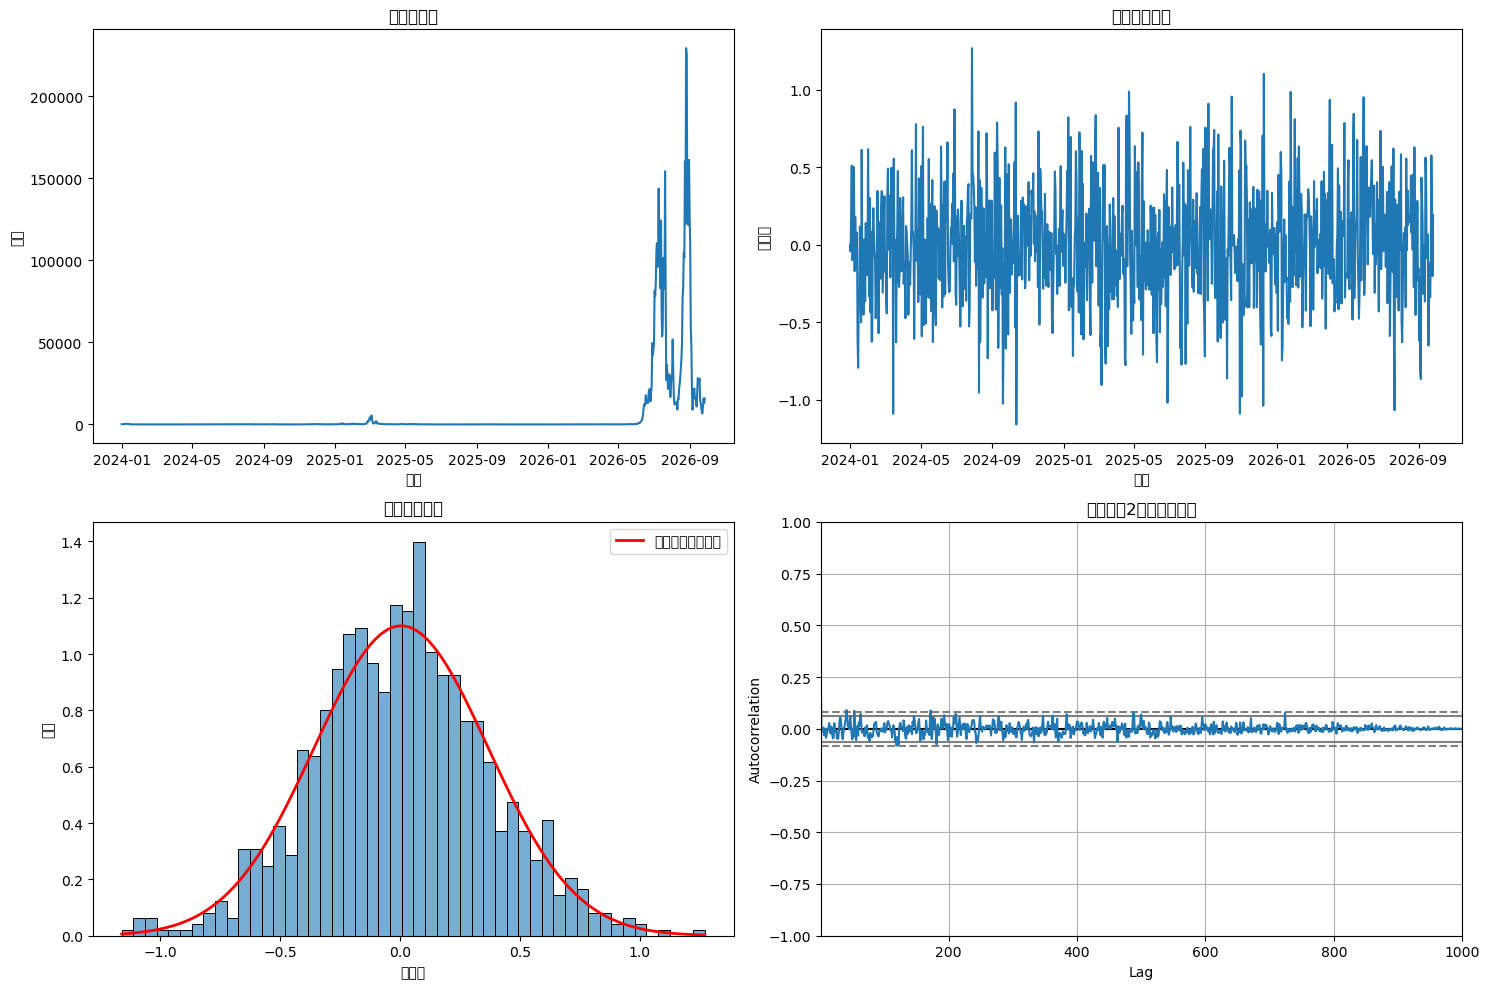

In [12]:
# プロットの設定
plt.figure(figsize=(15, 10))

# 1. 株価の時系列プロット
plt.subplot(2, 2, 1)
plt.plot(df.index, df['Price'])
plt.title('株価の推移')
plt.xlabel('日付')
plt.ylabel('株価')

# 2. 収益率の時系列プロット
plt.subplot(2, 2, 2)
plt.plot(df.index, df['Returns'])
plt.title('収益率の推移')
plt.xlabel('日付')
plt.ylabel('収益率')

# 3. 収益率の分布
plt.subplot(2, 2, 3)
sns.histplot(df['Returns'], bins=50, stat='density', alpha=0.6)
mu, std = stats.norm.fit(df['Returns'])
x = np.linspace(df['Returns'].min(), df['Returns'].max(), 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'r-', lw=2, label='正規分布フィット')
plt.title('収益率の分布')
plt.xlabel('収益率')
plt.ylabel('密度')
plt.legend()

# 4. 収益率の自己相関
plt.subplot(2, 2, 4)
pd.plotting.autocorrelation_plot(df['Returns']**2)
plt.title('収益率の2乗の自己相関')

plt.tight_layout()
plt.show()

## 4. ARCHモデルのフィッティング

archパッケージを使用して、ARCH(1)モデルをデータにフィッティングします。
モデルの推定結果からパラメータとその統計的有意性を確認します。

In [13]:
# ARCH(1)モデルのフィッティング
model = arch_model(df['Returns'], vol='ARCH', p=1)
results = model.fit(disp='off')

# 結果の表示
print(results.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -382.721
Distribution:                  Normal   AIC:                           771.442
Method:            Maximum Likelihood   BIC:                           786.165
                                        No. Observations:                 1000
Date:                Sat, Oct 25 2025   Df Residuals:                      999
Time:                        14:38:56   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         5.1667e-03  1.053e-02      0.490      0.624 

## 5. モデル診断と評価

フィットしたモデルの診断を行います：
1. 標準化残差の分析
2. モデルの適合度の評価

/tmp/ipykernel_216/759677535.py:37: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_216/759677535.py:37: UserWarning: Glyph 28310 (\N{CJK UNIFIED IDEOGRAPH-6E96}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_216/759677535.py:37: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_216/759677535.py:37: UserWarning: Glyph 27531 (\N{CJK UNIFIED IDEOGRAPH-6B8B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_216/759677535.py:37: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_216/759677535.py:37: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_216/759677535.py:37: UserWarning: Glyph 12503 (\N{KATAKANA LETTER PU}) missing from font(s) DejaVu 

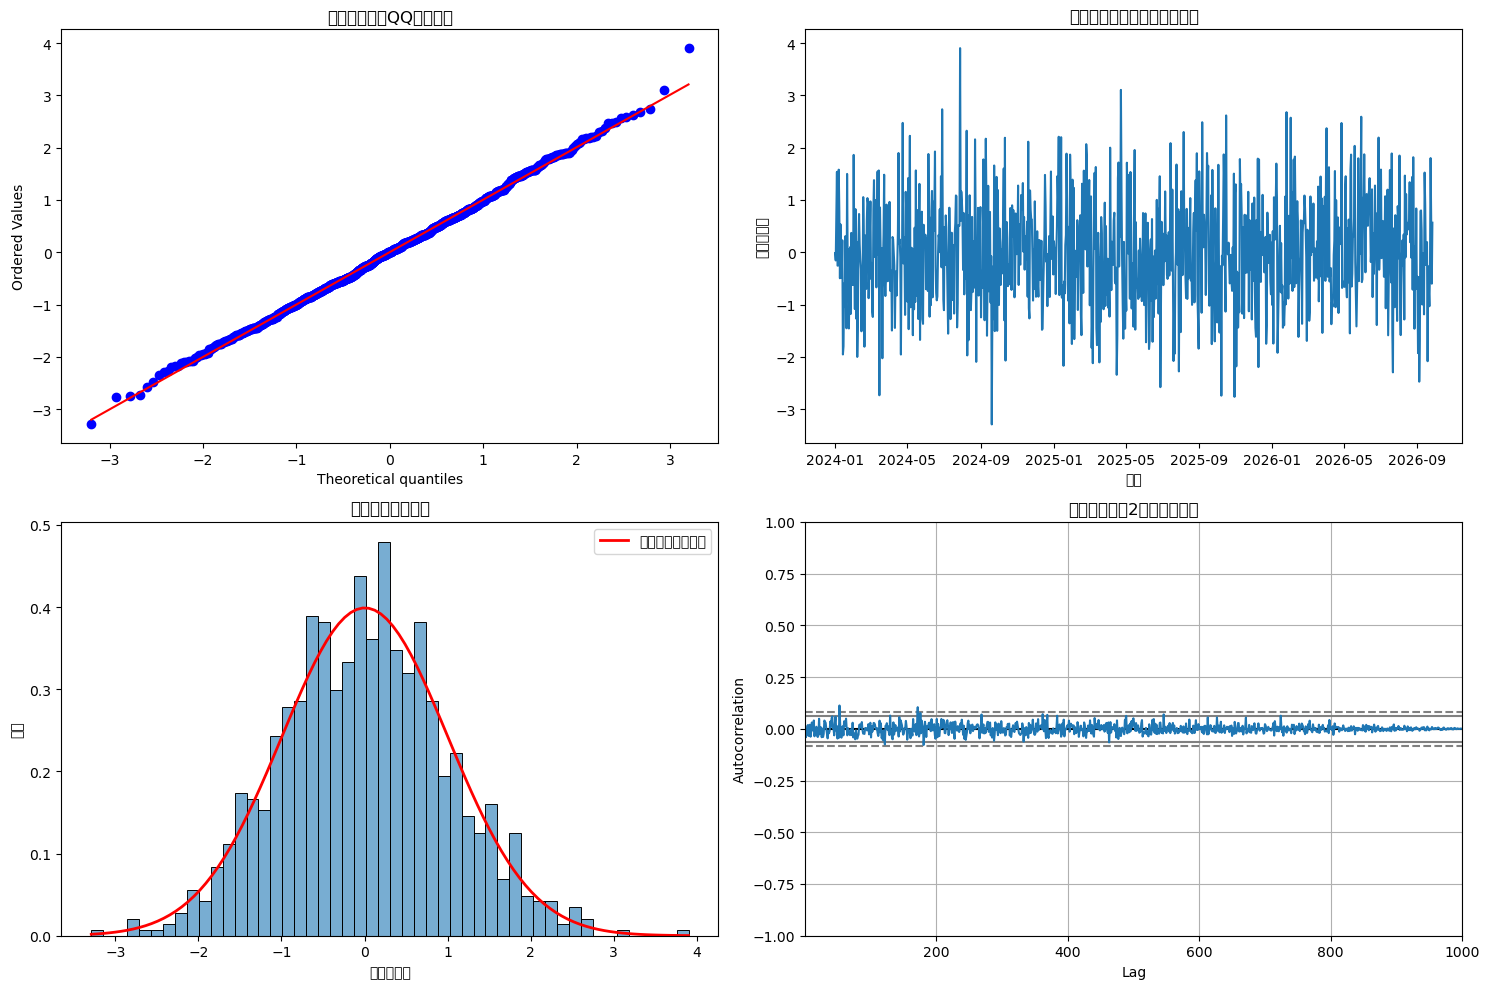

In [14]:
# 標準化残差の取得
residuals = results.resid
std_residuals = residuals / results.conditional_volatility

# プロットの設定
plt.figure(figsize=(15, 10))

# 1. 標準化残差のQQプロット
plt.subplot(2, 2, 1)
stats.probplot(std_residuals, dist="norm", plot=plt)
plt.title('標準化残差のQQプロット')

# 2. 標準化残差の時系列プロット
plt.subplot(2, 2, 2)
plt.plot(df.index, std_residuals)
plt.title('標準化残差の時系列プロット')
plt.xlabel('日付')
plt.ylabel('標準化残差')

# 3. 標準化残差の分布
plt.subplot(2, 2, 3)
sns.histplot(std_residuals, bins=50, stat='density', alpha=0.6)
mu, std = stats.norm.fit(std_residuals)
x = np.linspace(std_residuals.min(), std_residuals.max(), 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'r-', lw=2, label='正規分布フィット')
plt.title('標準化残差の分布')
plt.xlabel('標準化残差')
plt.ylabel('密度')
plt.legend()

# 4. 標準化残差の自己相関
plt.subplot(2, 2, 4)
pd.plotting.autocorrelation_plot(std_residuals**2)
plt.title('標準化残差の2乗の自己相関')

plt.tight_layout()
plt.show()

## 6. 予測と信頼区間の計算

フィットしたモデルを使用して、将来のボラティリティを予測し、信頼区間を計算します。

/tmp/ipykernel_216/3702378475.py:18: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(ci_lower),
/home/kazumasa/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20104 (\N{CJK UNIFIED IDEOGRAPH-4E88}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/kazumasa/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28204 (\N{CJK UNIFIED IDEOGRAPH-6E2C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/kazumasa/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12508 (\N{KATAKANA LETTER BO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/kazumasa/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/kazumasa/anaconda3/lib

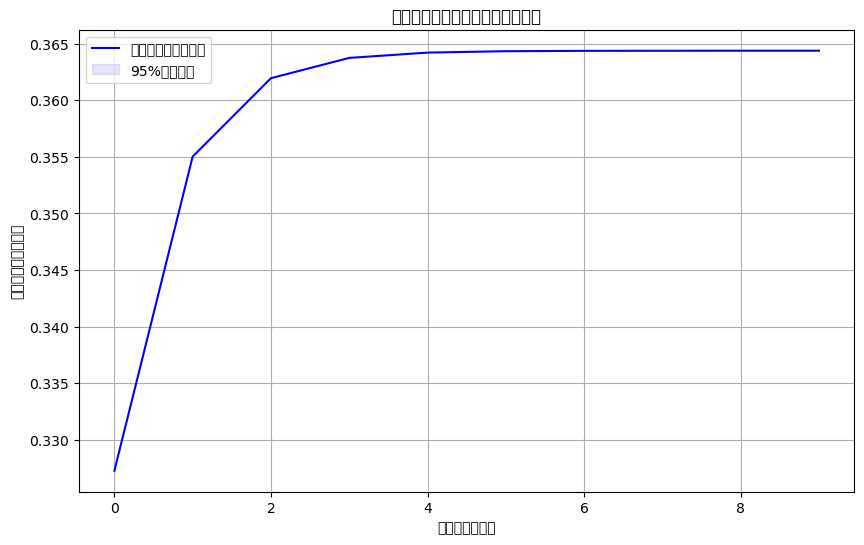


ボラティリティ予測結果:
            Predicted_Volatility  CI_Lower  CI_Upper
2026-09-27              0.327256       NaN  0.635573
2026-09-28              0.355027       NaN  0.689507
2026-09-29              0.361955       NaN  0.702963
2026-09-30              0.363750       NaN  0.706449
2026-10-01              0.364219       NaN  0.707360
2026-10-02              0.364342       NaN  0.707599
2026-10-03              0.364374       NaN  0.707662
2026-10-04              0.364383       NaN  0.707678
2026-10-05              0.364385       NaN  0.707682
2026-10-06              0.364386       NaN  0.707683


/tmp/ipykernel_216/3702378475.py:31: RuntimeWarning: invalid value encountered in sqrt
  'CI_Lower': np.sqrt(ci_lower),


In [15]:
# 予測期間の設定
horizon = 10
forecasts = results.forecast(horizon=horizon)

# 予測値と信頼区間の取得
variance_forecasts = forecasts.variance
variance_forecasts_mean = variance_forecasts.values.ravel()  # 1次元配列に変換

# 信頼区間の計算（95%）
variance_std = np.sqrt(2 * variance_forecasts_mean**2)  # 理論的な標準偏差
ci_lower = variance_forecasts_mean - 1.96 * variance_std
ci_upper = variance_forecasts_mean + 1.96 * variance_std

# 予測値のプロット
plt.figure(figsize=(10, 6))
plt.plot(range(horizon), np.sqrt(variance_forecasts_mean), 'b-', label='予測ボラティリティ')
plt.fill_between(range(horizon), 
                 np.sqrt(ci_lower), 
                 np.sqrt(ci_upper), 
                 color='b', alpha=0.1, label='95%信頼区間')
plt.title('ボラティリティの予測と信頼区間')
plt.xlabel('予測期間（日）')
plt.ylabel('予測ボラティリティ')
plt.legend()
plt.grid(True)
plt.show()

# 予測値の表示
forecast_df = pd.DataFrame({
    'Predicted_Volatility': np.sqrt(variance_forecasts_mean),
    'CI_Lower': np.sqrt(ci_lower),
    'CI_Upper': np.sqrt(ci_upper)
}, index=pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=horizon, freq='D'))
print("\nボラティリティ予測結果:")
print(forecast_df)

## 7. GARCHモデルの実装

GARCH（Generalized Autoregressive Conditional Heteroskedasticity）モデルは、ARCHモデルの拡張版です。
GARCH(p,q)モデルは以下のように定義されます：

$$\sigma_t^2 = \omega + \sum_{i=1}^{q}\alpha_i\epsilon_{t-i}^2 + \sum_{j=1}^{p}\beta_j\sigma_{t-j}^2$$

ここでは、最も一般的なGARCH(1,1)モデルを実装します：
- p=1: 過去1期のボラティリティに依存
- q=1: 過去1期のショックに依存


In [ ]:
# GARCH(1,1)モデルのフィッティング
garch_model = arch_model(df['Returns'], vol='GARCH', p=1, q=1)
garch_results = garch_model.fit(disp='off')

# 結果の表示
print(garch_results.summary())


## 8. ARCHモデルとGARCHモデルの比較

2つのモデルを情報量規準（AIC、BIC）と対数尤度で比較します。
一般的に、値が小さいほど良いモデルとされます。


In [ ]:
# モデルの比較
comparison_df = pd.DataFrame({
    'Model': ['ARCH(1)', 'GARCH(1,1)'],
    'Log-Likelihood': [results.loglikelihood, garch_results.loglikelihood],
    'AIC': [results.aic, garch_results.aic],
    'BIC': [results.bic, garch_results.bic]
})

print("モデル比較:")
print(comparison_df)
print("\n")

# パラメータの比較
print("ARCHモデルのパラメータ:")
print(f"omega (ω): {results.params['omega']:.4f}")
print(f"alpha[1] (α₁): {results.params['alpha[1]']:.4f}")
print("\n")

print("GARCHモデルのパラメータ:")
print(f"omega (ω): {garch_results.params['omega']:.6f}")
print(f"alpha[1] (α₁): {garch_results.params['alpha[1]']:.4f}")
print(f"beta[1] (β₁): {garch_results.params['beta[1]']:.4f}")
print(f"持続性 (α₁ + β₁): {garch_results.params['alpha[1]'] + garch_results.params['beta[1]']:.4f}")


## 9. GARCHモデルの診断

GARCHモデルの標準化残差を分析し、モデルの適合度を評価します。


In [ ]:
# GARCHモデルの標準化残差の取得
garch_residuals = garch_results.resid
garch_std_residuals = garch_residuals / garch_results.conditional_volatility

# プロットの設定
plt.figure(figsize=(15, 10))

# 1. 標準化残差のQQプロット
plt.subplot(2, 2, 1)
stats.probplot(garch_std_residuals, dist="norm", plot=plt)
plt.title('GARCH標準化残差のQQプロット')

# 2. 標準化残差の時系列プロット
plt.subplot(2, 2, 2)
plt.plot(df.index, garch_std_residuals)
plt.title('GARCH標準化残差の時系列プロット')
plt.xlabel('日付')
plt.ylabel('標準化残差')

# 3. 標準化残差の分布
plt.subplot(2, 2, 3)
sns.histplot(garch_std_residuals, bins=50, stat='density', alpha=0.6)
mu, std = stats.norm.fit(garch_std_residuals)
x = np.linspace(garch_std_residuals.min(), garch_std_residuals.max(), 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'r-', lw=2, label='正規分布フィット')
plt.title('GARCH標準化残差の分布')
plt.xlabel('標準化残差')
plt.ylabel('密度')
plt.legend()

# 4. 標準化残差の2乗の自己相関
plt.subplot(2, 2, 4)
pd.plotting.autocorrelation_plot(garch_std_residuals**2)
plt.title('GARCH標準化残差の2乗の自己相関')

plt.tight_layout()
plt.show()


## 10. 条件付きボラティリティの比較

ARCHモデルとGARCHモデルの条件付きボラティリティを比較し、
両モデルがボラティリティをどのように捉えているかを視覚化します。


In [ ]:
# 条件付きボラティリティの比較
plt.figure(figsize=(15, 12))

# 1. 収益率の絶対値
plt.subplot(3, 1, 1)
plt.plot(df.index, np.abs(df['Returns']), label='収益率の絶対値', alpha=0.5)
plt.title('収益率の絶対値')
plt.xlabel('日付')
plt.ylabel('絶対値')
plt.legend()
plt.grid(True)

# 2. ARCHモデルの条件付きボラティリティ
plt.subplot(3, 1, 2)
plt.plot(df.index, results.conditional_volatility, label='ARCH(1)', color='blue')
plt.plot(df.index, np.abs(df['Returns']), label='収益率の絶対値', alpha=0.3, color='gray')
plt.title('ARCHモデルの条件付きボラティリティ')
plt.xlabel('日付')
plt.ylabel('ボラティリティ')
plt.legend()
plt.grid(True)

# 3. GARCHモデルの条件付きボラティリティ
plt.subplot(3, 1, 3)
plt.plot(df.index, garch_results.conditional_volatility, label='GARCH(1,1)', color='green')
plt.plot(df.index, np.abs(df['Returns']), label='収益率の絶対値', alpha=0.3, color='gray')
plt.title('GARCHモデルの条件付きボラティリティ')
plt.xlabel('日付')
plt.ylabel('ボラティリティ')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 両モデルの直接比較
plt.figure(figsize=(15, 6))
plt.plot(df.index, results.conditional_volatility, label='ARCH(1)', alpha=0.7)
plt.plot(df.index, garch_results.conditional_volatility, label='GARCH(1,1)', alpha=0.7)
plt.plot(df.index, np.abs(df['Returns']), label='収益率の絶対値', alpha=0.3, color='gray')
plt.title('ARCHモデルとGARCHモデルの条件付きボラティリティ比較')
plt.xlabel('日付')
plt.ylabel('ボラティリティ')
plt.legend()
plt.grid(True)
plt.show()


## 11. GARCHモデルによる予測

GARCHモデルを使用して、将来のボラティリティを予測し、ARCHモデルとの予測を比較します。


In [ ]:
# GARCHモデルの予測
horizon = 10
garch_forecasts = garch_results.forecast(horizon=horizon)

# GARCH予測値の取得
garch_variance_forecasts = garch_forecasts.variance
garch_variance_forecasts_mean = garch_variance_forecasts.values.ravel()

# 予測値の比較プロット
plt.figure(figsize=(15, 6))

# 過去のボラティリティをプロット（最後の100日間）
plot_start = -100
plt.plot(range(plot_start, 0), results.conditional_volatility.values[plot_start:], 
         'b-', label='ARCH(1) 実績', linewidth=2)
plt.plot(range(plot_start, 0), garch_results.conditional_volatility.values[plot_start:], 
         'g-', label='GARCH(1,1) 実績', linewidth=2)

# ARCH予測
plt.plot(range(0, horizon), np.sqrt(variance_forecasts_mean), 
         'b--', label='ARCH(1) 予測', linewidth=2, marker='o')

# GARCH予測
plt.plot(range(0, horizon), np.sqrt(garch_variance_forecasts_mean), 
         'g--', label='GARCH(1,1) 予測', linewidth=2, marker='o')

plt.axvline(x=0, color='r', linestyle=':', alpha=0.5, label='予測開始点')
plt.title('ARCHモデルとGARCHモデルのボラティリティ予測比較')
plt.xlabel('期間（日）')
plt.ylabel('ボラティリティ')
plt.legend()
plt.grid(True)
plt.show()

# 予測値の詳細表示
forecast_comparison_df = pd.DataFrame({
    'ARCH_Volatility': np.sqrt(variance_forecasts_mean),
    'GARCH_Volatility': np.sqrt(garch_variance_forecasts_mean),
    'Difference': np.sqrt(garch_variance_forecasts_mean) - np.sqrt(variance_forecasts_mean)
}, index=pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=horizon, freq='D'))

print("\nボラティリティ予測比較:")
print(forecast_comparison_df)

# 統計量の表示
print("\n予測統計量:")
print(f"ARCH平均予測ボラティリティ: {np.sqrt(variance_forecasts_mean).mean():.6f}")
print(f"GARCH平均予測ボラティリティ: {np.sqrt(garch_variance_forecasts_mean).mean():.6f}")
print(f"予測値の平均差分: {forecast_comparison_df['Difference'].mean():.6f}")


## 12. まとめ

### ARCHモデルとGARCHモデルの違い

**ARCHモデル（Autoregressive Conditional Heteroskedasticity）**
- ボラティリティが過去のショック（収益率の2乗）のみに依存
- シンプルな構造だが、多くのパラメータが必要になることがある
- 式: $\sigma_t^2 = \omega + \alpha_1\epsilon_{t-1}^2$

**GARCHモデル（Generalized ARCH）**
- ボラティリティが過去のショックと過去のボラティリティの両方に依存
- より少ないパラメータで複雑なボラティリティ構造を表現可能
- 式: $\sigma_t^2 = \omega + \alpha_1\epsilon_{t-1}^2 + \beta_1\sigma_{t-1}^2$

### 主な特徴
1. **持続性**: GARCH(1,1)の持続性パラメータ（α₁ + β₁）は、ボラティリティショックの持続性を示す
2. **情報量規準**: AIC、BICが低いモデルが統計的に優れている
3. **予測**: GARCHモデルは通常、より滑らかで安定した予測を生成する
